Scoring in next 10 actions model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/")

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from vaep.config import vaep_modelling_file_path
from vaep.domain.contracts.modelling_data_contract import ModellingDataContract
from vaep.domain.modelling.supermodel import SuperXGBClassifier
from vaep.domain.modelling.model_evaluation import XGBClassifierEvaluator
from vaep.domain.preprocessing.preprocessing import *

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [3]:
new_version = 1
model_name = "vaep_conceding"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/vaep/model_outputs/models/"
preproc_file_path = ""

Comparison Model

In [4]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/vaep/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/vaep/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [5]:
RESPONSE = ModellingDataContract.RESPONSE_CONCEDES

Features

In [6]:
FEATURES = ModellingDataContract.feature_list_scores

Load Data

In [7]:
modelling_data = pd.read_csv(vaep_modelling_file_path)
modelling_data.tail()

,match_id,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,action_type_a0,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_type_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,action_type_a1,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_type_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,action_type_a2,type_Kic

Preprocess Data

In [8]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [9]:
training_data = modelling_data[modelling_data[RESPONSE+"TrainingSet"]]
test_data = modelling_data[modelling_data[RESPONSE+"TestSet"]]
cal_data = modelling_data[modelling_data[RESPONSE+"ValidationSet"]]

In [10]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [11]:
y_train.mean(), y_test.mean(), y_cal.mean()

(0.022888104614380355, 0.02288767684013968, 0.022886418483206078)

In [12]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]
X_cal_preproc = X_cal[FEATURES]

Load Model

In [13]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

In [14]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7394302461640807, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.006998134138074297, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4995977080992783, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=None,
              min_child_weight=25, missing=nan, monotone_constraints={},
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Get Predictions

In [15]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)
train_probas = super_xgb.predict_proba(X_train_preproc)[:, 1]
test_probas = super_xgb.predict_proba(X_test_preproc)[:, 1]
train_cal_probas = super_xgb.predict_proba(X_train_preproc, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test_preproc, calibrate=True)

Compare Model

In [16]:
# compare_train_data = pd.read_csv(compare_train_predictions_file_path)
# compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [17]:
# compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
#                                                           'xgb_probas':'old_probas'})
# compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
#                                                         'xgb_probas':'old_probas'})

In [18]:
# training_data.shape, compare_train_data.shape

In [19]:
# training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
# test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [20]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas
training_data['xgb_cal_probas'] = train_cal_probas
training_data[RESPONSE] = training_data[RESPONSE].astype(int)

train_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                       # compare_name='xgb_probas',
                                       # compare_label_name="xgb_preds"
                                       )


In [21]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas
test_data['xgb_cal_probas'] = test_cal_probas
test_data[RESPONSE] = test_data[RESPONSE].astype(int)

test_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                    #    compare_name = "xgb_probas",
                                    #    compare_label_name="xgb_preds"
                                       )

Model Averages

In [22]:
training_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas']].describe()

,concedes,xgb_probas,xgb_cal_probas
count,606647.000000,606647.000000,606647.000000
mean,0.022888,0.024522,0.023035
std,0.149547,0.035009,0.027372
min,0.000000,0.002131,0.002449
25%,0.000000,0.007961,0.008501
50%,0.000000,0.013171,0.013641
75%,0.000000,0.026533,0.026212
max,1.000000,0.748108,0.431286


In [23]:
test_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas']].describe()

,concedes,xgb_probas,xgb_cal_probas
count,189578.000000,189578.000000,189578.000000
mean,0.022888,0.024617,0.023128
std,0.149546,0.034866,0.027315
min,0.000000,0.002214,0.002539
25%,0.000000,0.007982,0.008522
50%,0.000000,0.013261,0.013729
75%,0.000000,0.026715,0.026379
max,1.000000,0.772456,0.441931


Plots

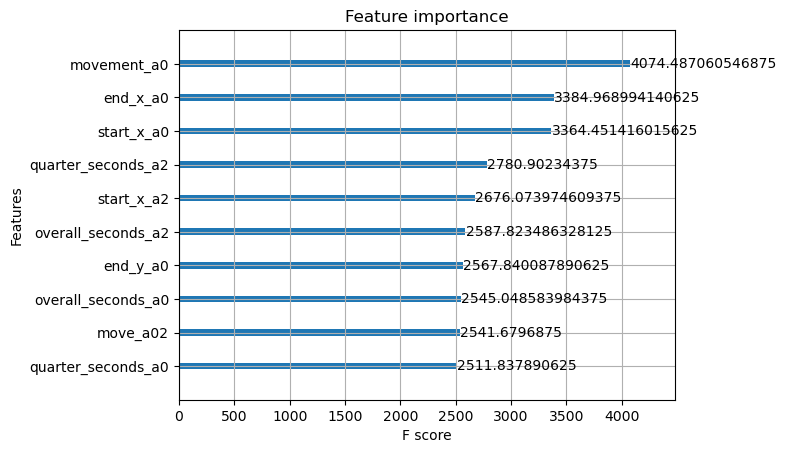

In [24]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

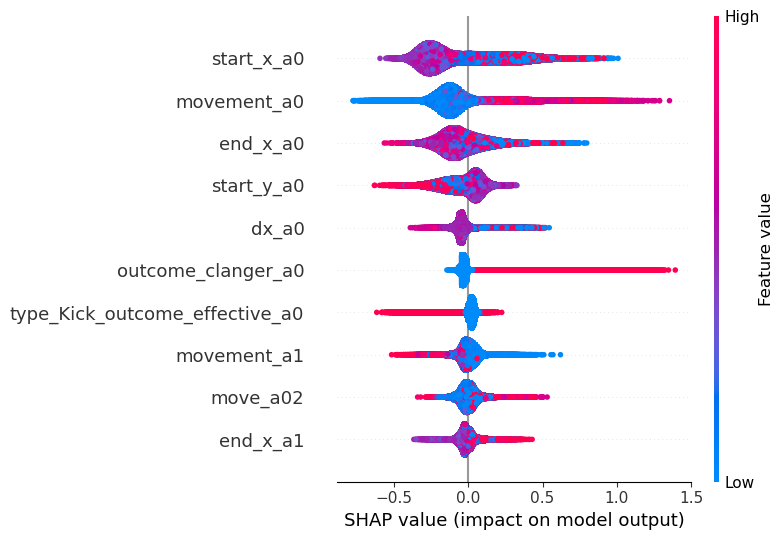

In [25]:
train_xgb_evals.plot_shap_summary_plot()

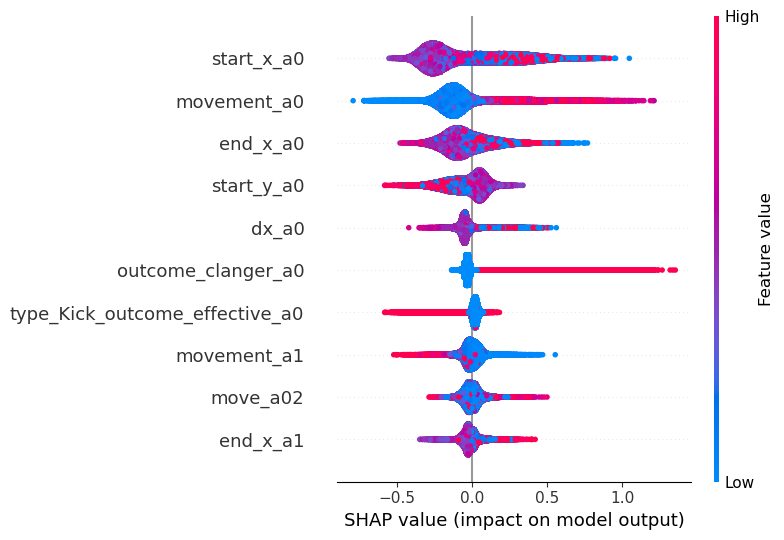

In [26]:
test_xgb_evals.plot_shap_summary_plot()

In [27]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['start_x_a0',
 'movement_a0',
 'end_x_a0',
 'start_y_a0',
 'dx_a0',
 'outcome_clanger_a0',
 'type_Kick_outcome_effective_a0',
 'movement_a1',
 'move_a02',
 'end_x_a1']

In [28]:
# for col in top_10_features:
#     test_xgb_evals.plot_pdp([col])

In [29]:
# for col in top_10_features:
#     train_xgb_evals.plot_ice([col])
#     test_xgb_evals.plot_ice([col])

start_x_a0
movement_a0
end_x_a0
start_y_a0
dx_a0
outcome_clanger_a0
type_Kick_outcome_effective_a0
movement_a1
move_a02
end_x_a1


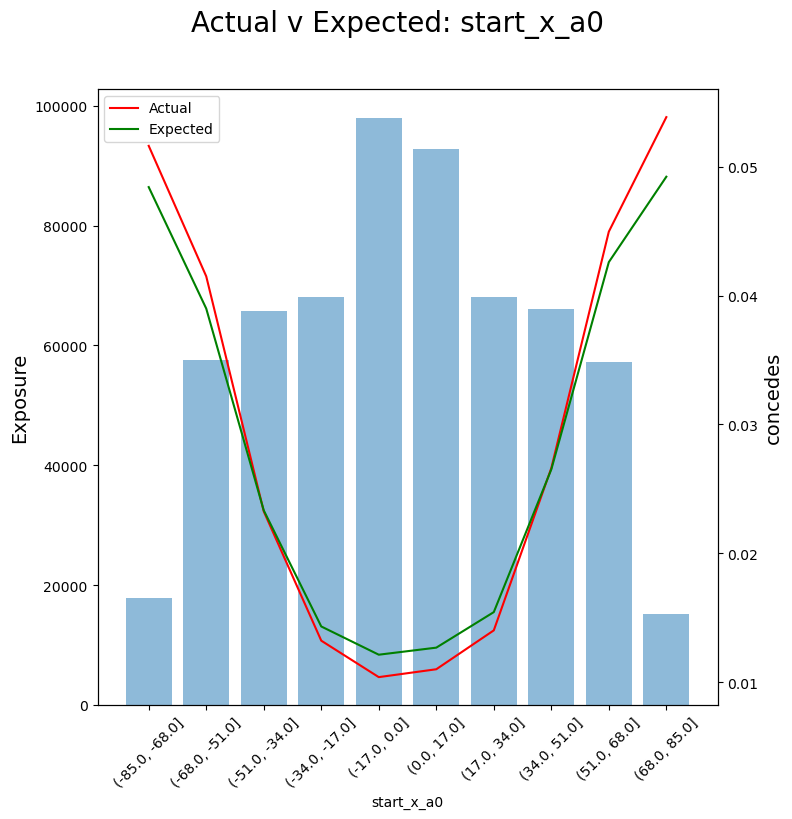

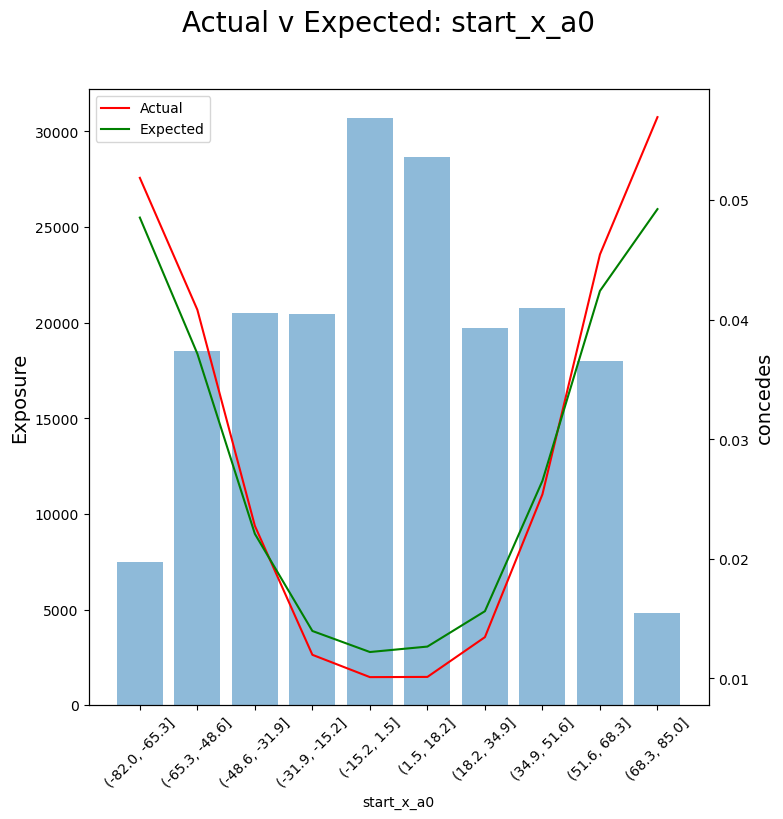

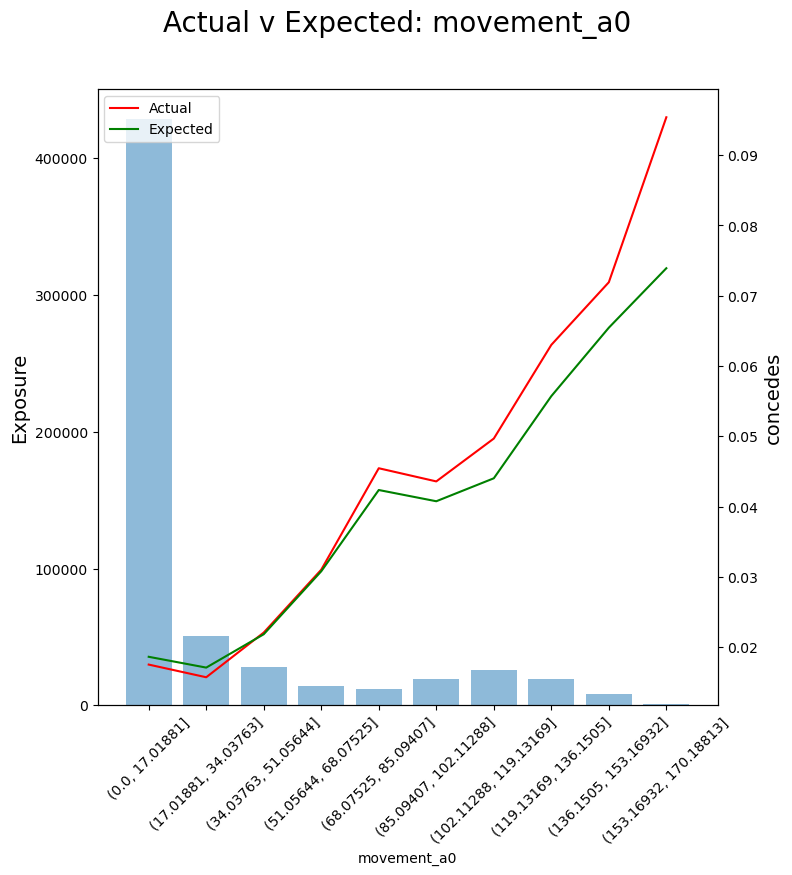

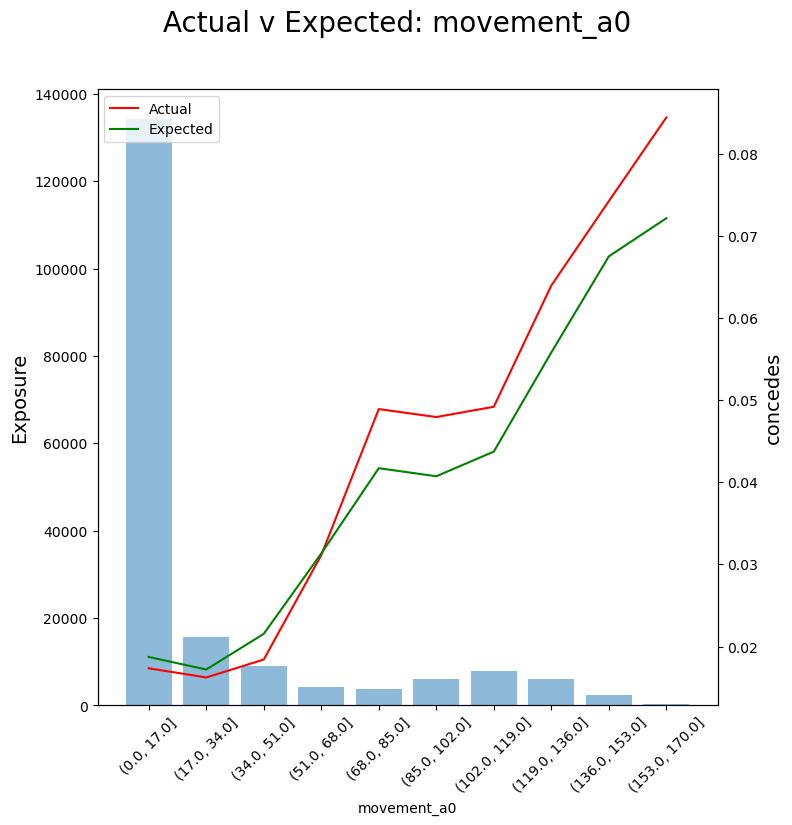

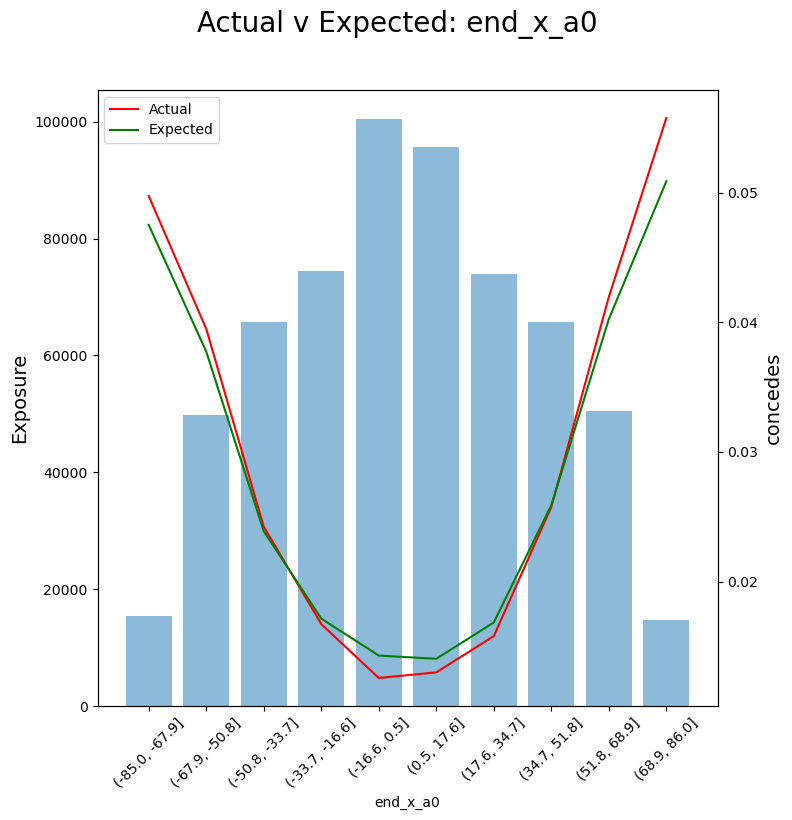

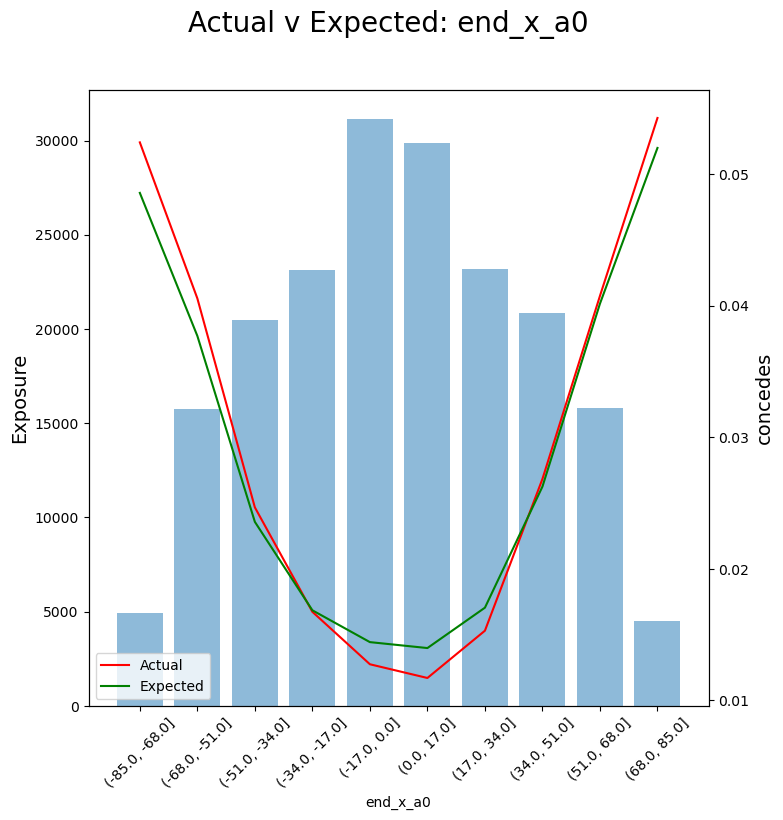

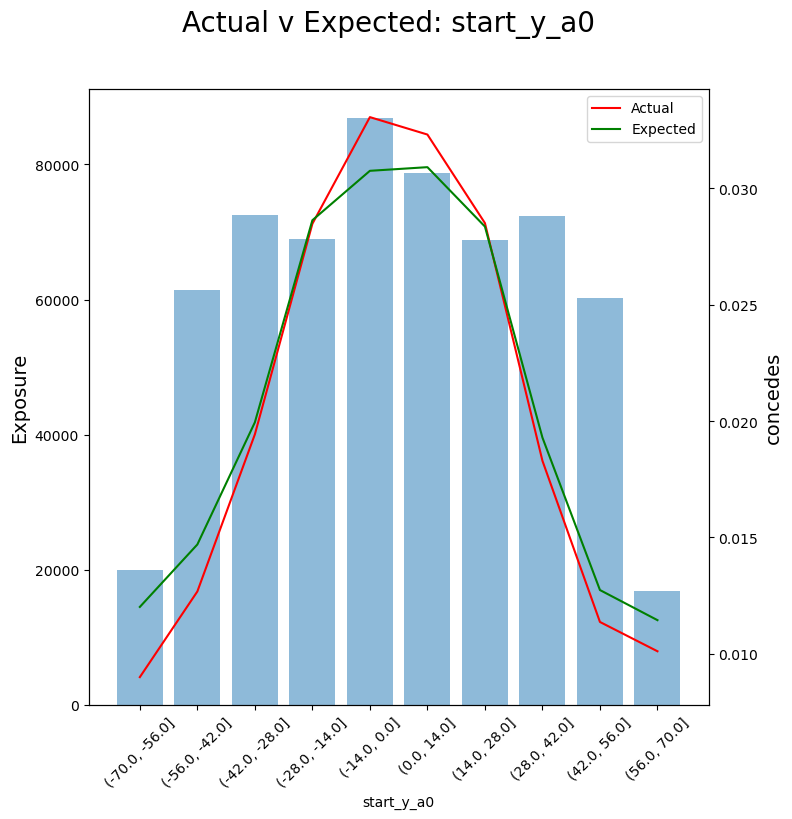

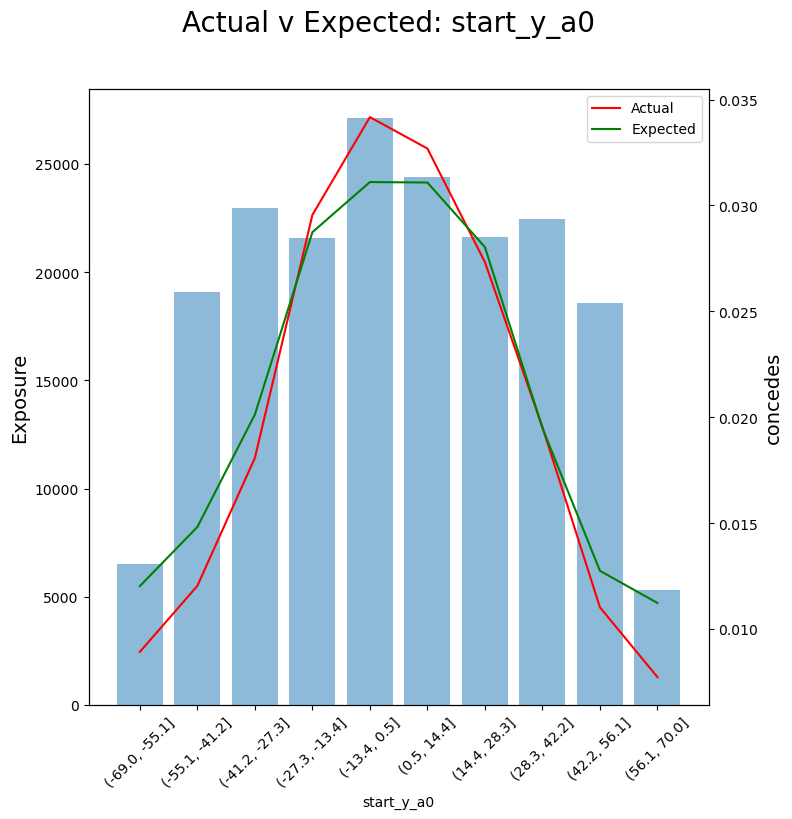

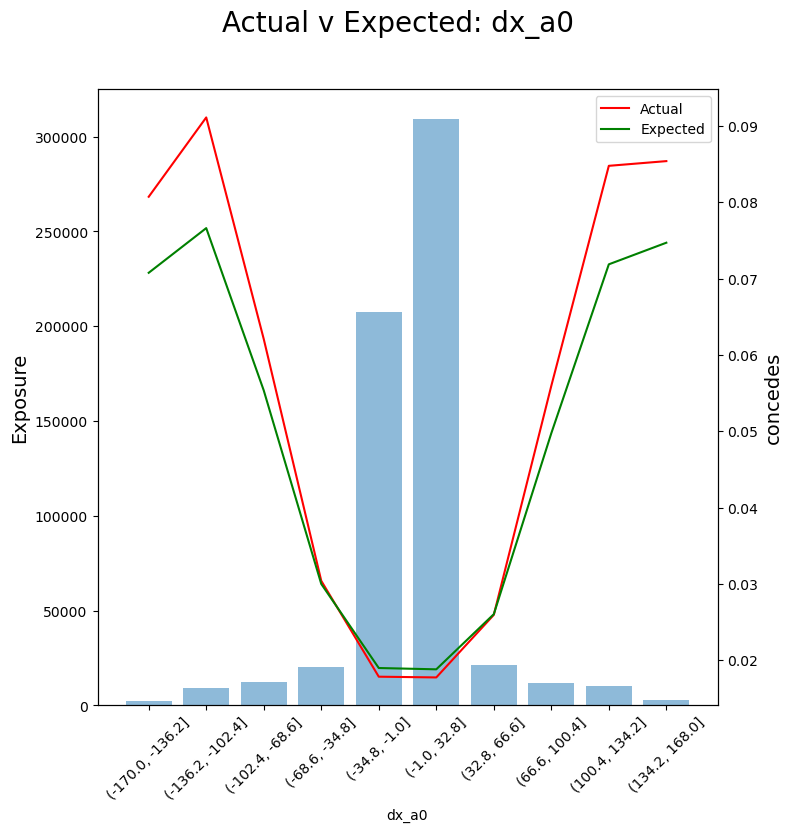

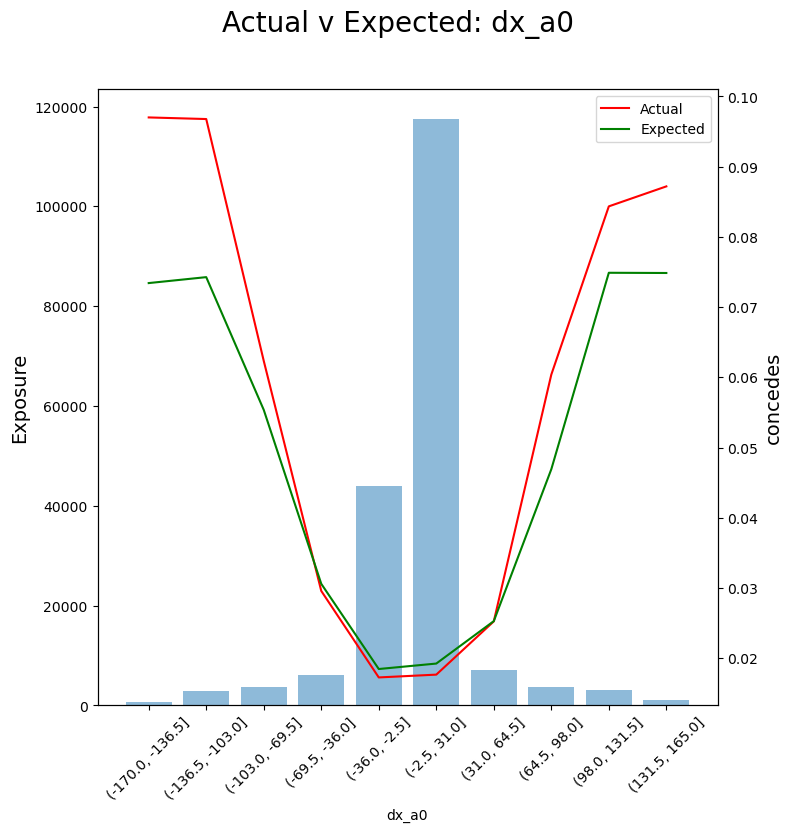

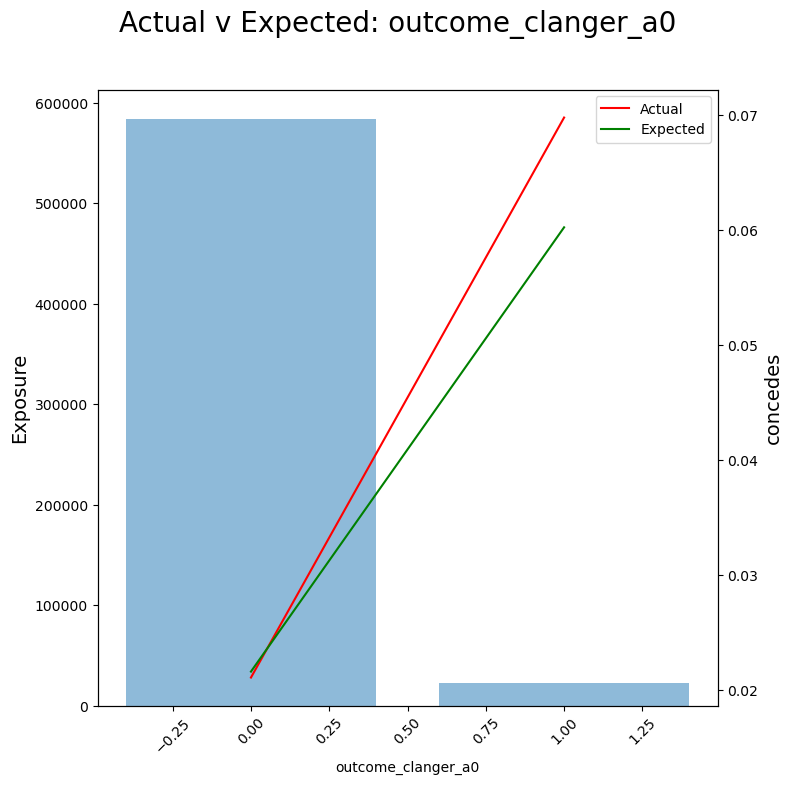

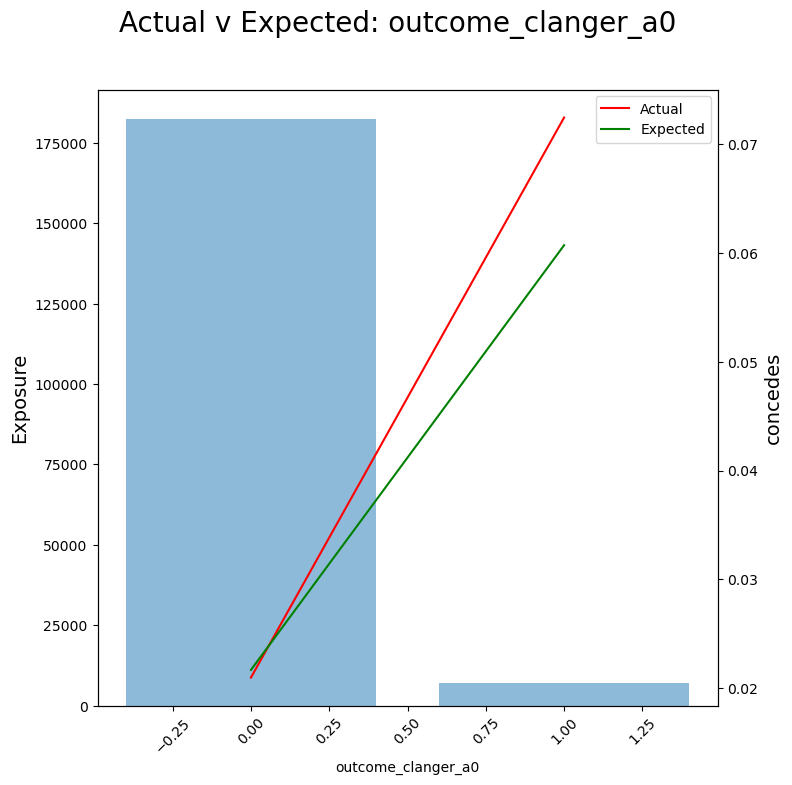

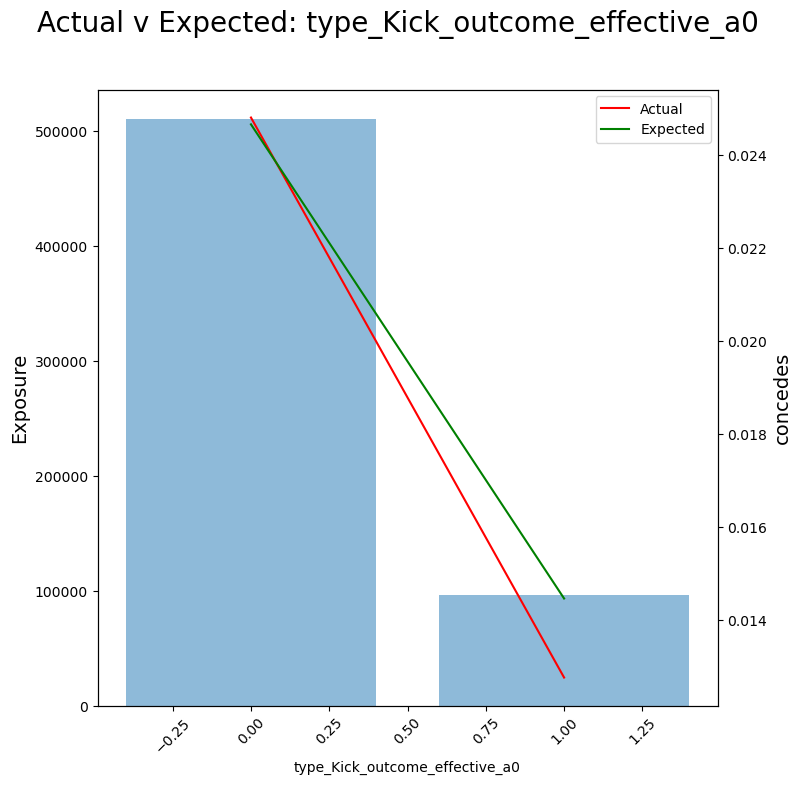

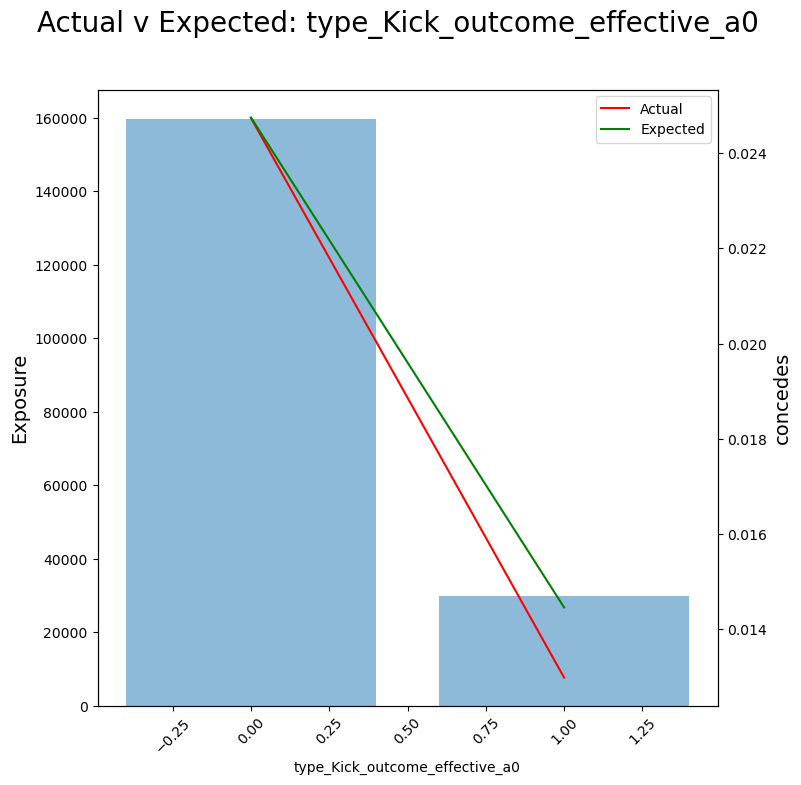

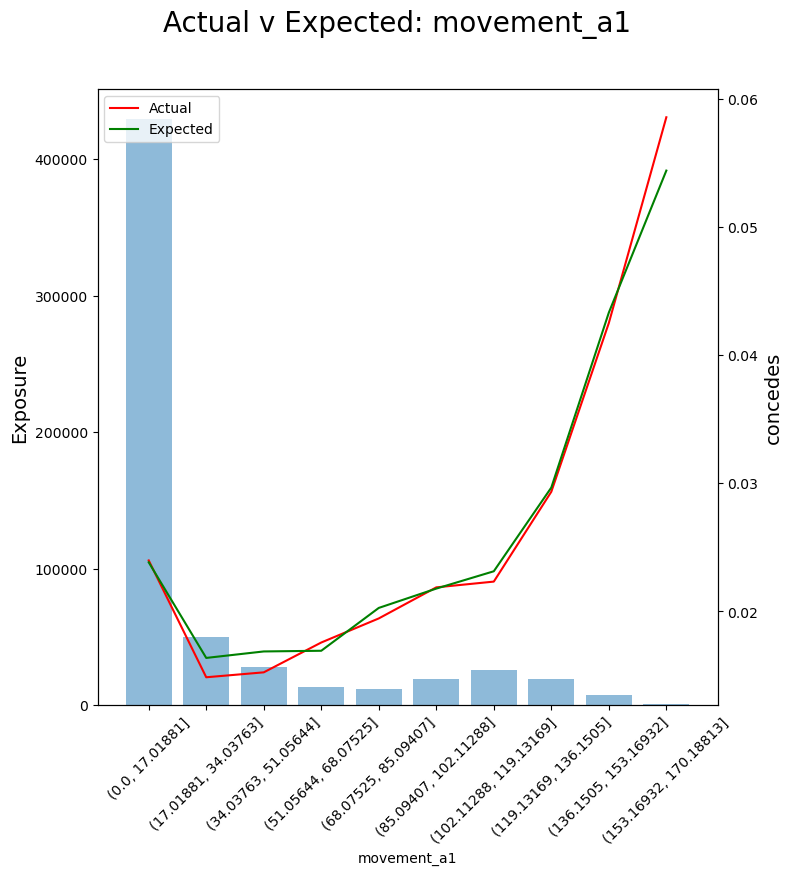

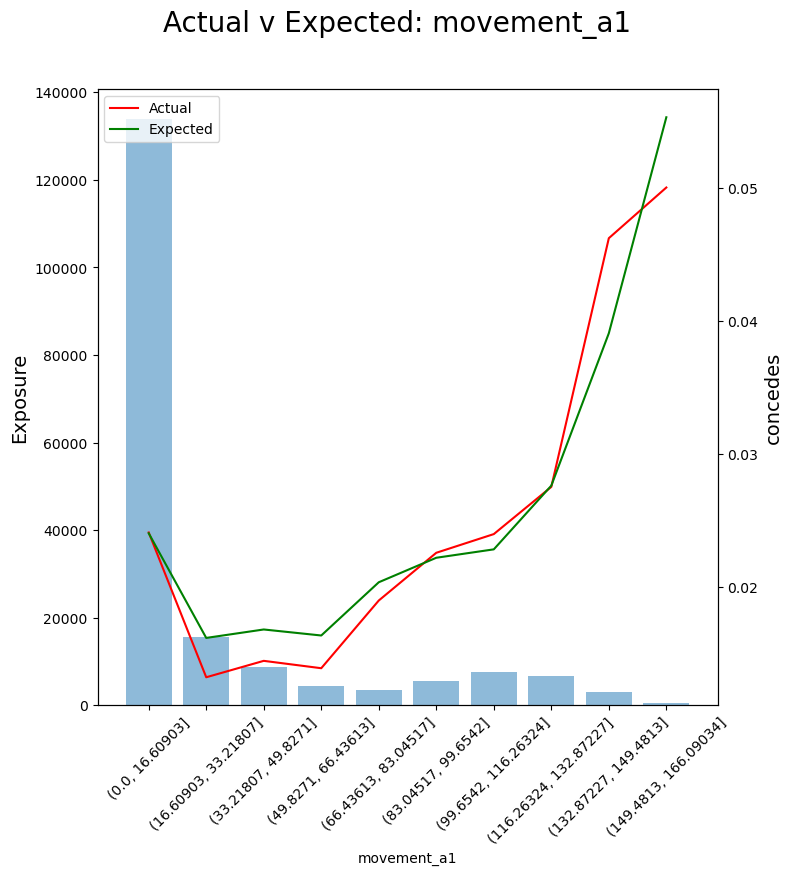

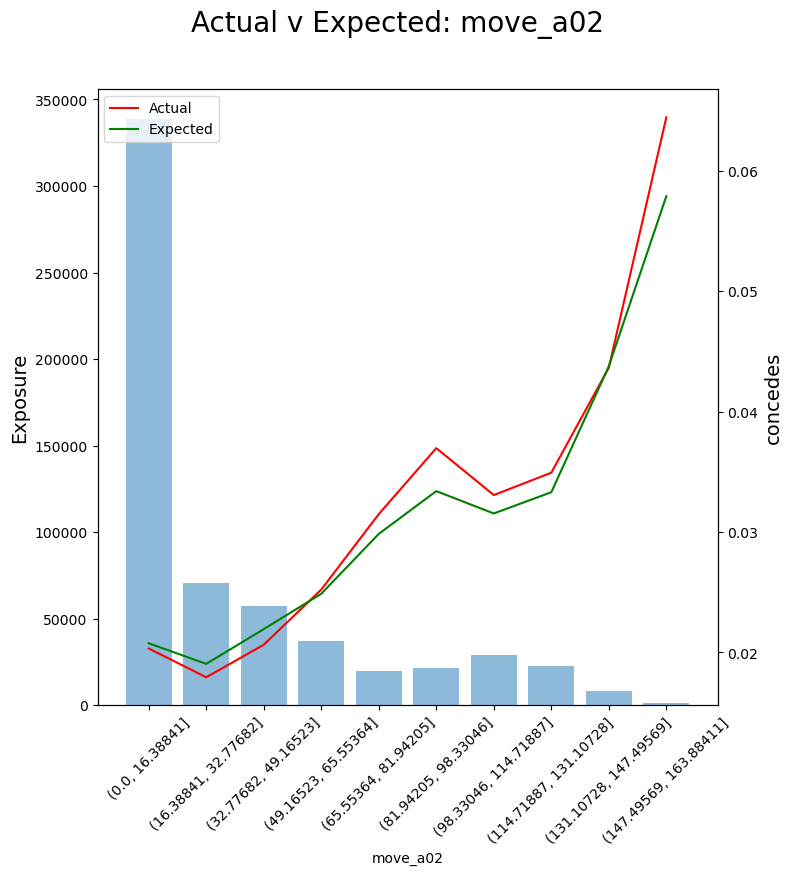

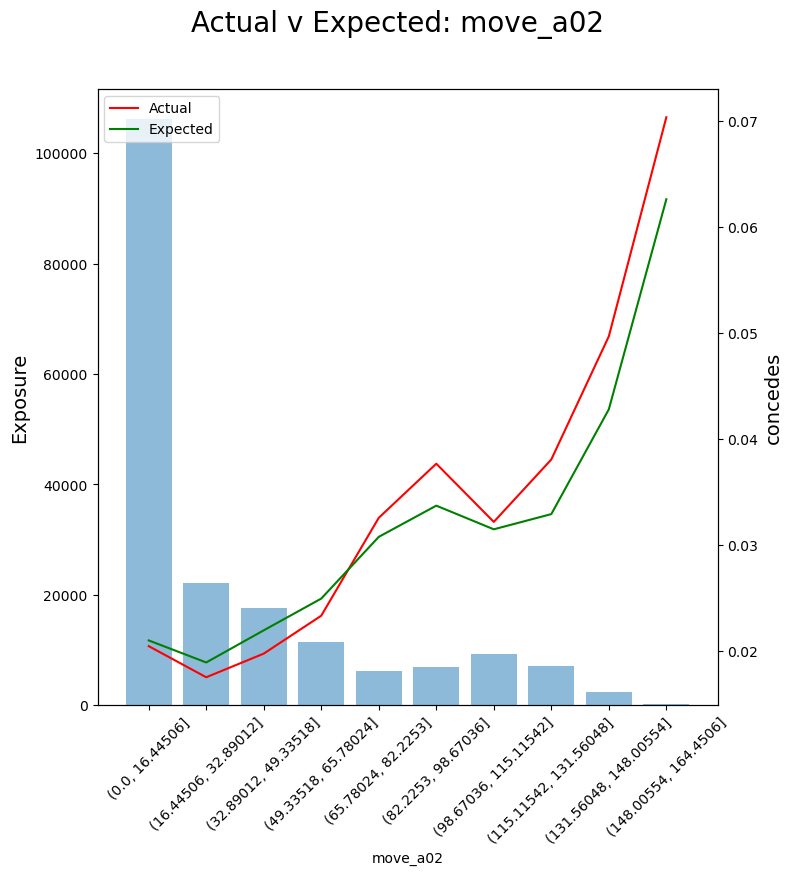

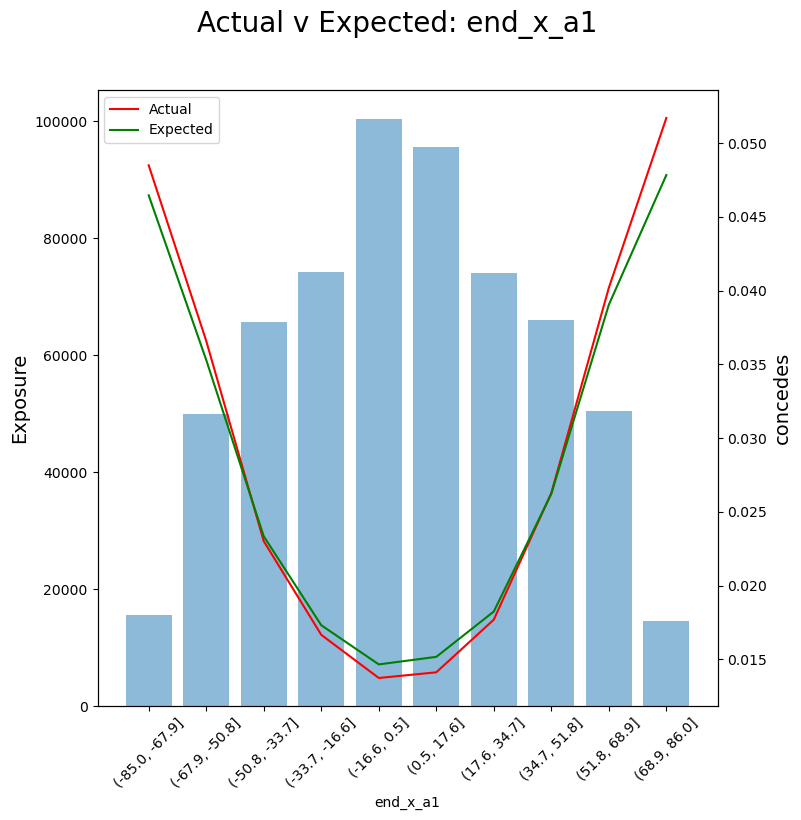

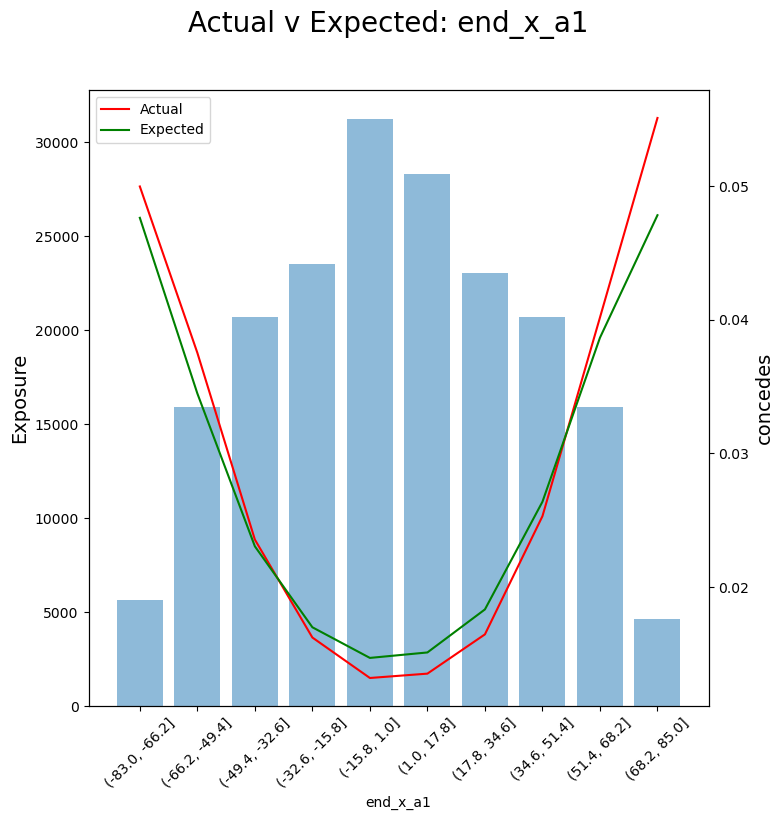

In [30]:
for col in top_10_features:
    print(col)
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [31]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.0894
Expected Log-Loss: 	0.0984


(0.08936388685623589, 0.09839326734590143)

In [32]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss() 

Expected Brier Score: 	0.0207
Expected Brier Score: 	0.0216


(0.020682169229257884, 0.021617619448268576)

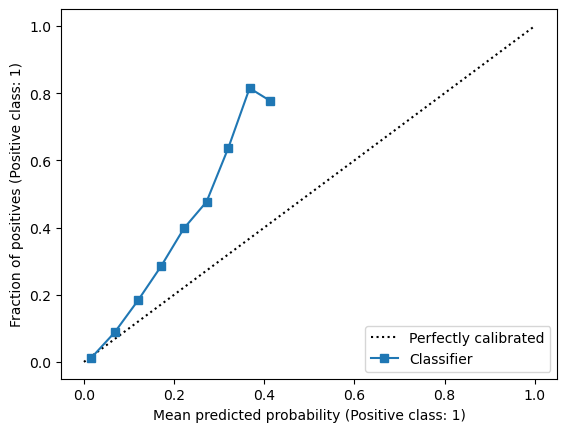

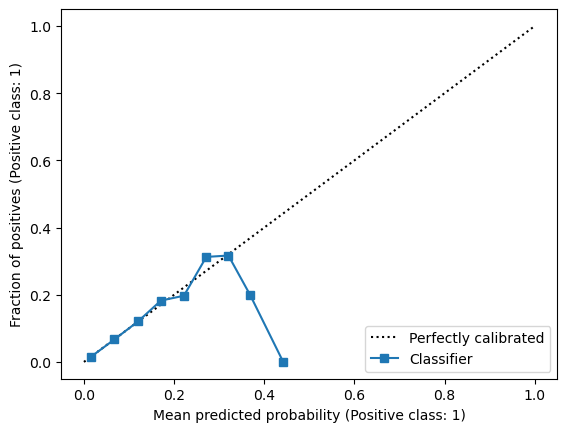

In [33]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)